In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier  # or GradientBoostingClassifier if you prefer sklearn-only
import shap, seaborn as sns, matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

df = pd.read_csv("../data/youtube_shorts_tiktok_trends_2025.csv_ML.csv")


In [37]:
# Sentiment from raw titles (aligns row-for-row with the _ML file)
sia = SentimentIntensityAnalyzer()
df_raw = pd.read_csv("../data/youtube_shorts_tiktok_trends_2025.csv", usecols=["title"])
df["title_sentiment"] = df_raw["title"].fillna("").apply(lambda t: sia.polarity_scores(t)["compound"])


In [38]:
import sys
sys.path.append("../src")

from preprocess import map_labels, clean_features, get_feature_matrix
from model_utils import rate_video


In [39]:
df_country = pd.read_csv("../data/country_platform_summary_2025.csv")
df_country.head()

df_country.rename(columns={'country': 'region'}, inplace=True)

df_enriched = df.merge(
    df_country[['region', 'platform', 'median_er', 'avg_velocity', 'avg_engagement_per_1k']],
    on=['region', 'platform'],
    how='left'
)
# Compute region+platform "strength" from your own ML data
region_platform_strength = (
    df.groupby(['region', 'platform'])
      .agg({
          'views_per_day': 'mean',
          'like_rate': 'mean',
          'share_rate': 'mean',
          'rel_like': 'mean',
          'rel_share': 'mean'
      })
      .reset_index()
      .rename(columns={
          'views_per_day': 'region_platform_avg_views_per_day',
          'like_rate': 'region_platform_avg_like_rate',
          'share_rate': 'region_platform_avg_share_rate',
          'rel_like': 'region_platform_avg_rel_like',
          'rel_share': 'region_platform_avg_rel_share'
      })
)

region_platform_strength.head()




,region,platform,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share
0,Africa,tiktok,0.125424,0.237473,0.070539,0.172764,0.334977
1,Africa,youtube,0.103872,0.205414,0.059469,0.014196,0.125933
2,Americas,tiktok,0.125526,0.229555,0.071589,0.146339,0.338209
3,Americas,youtube,0.103101,0.203117,0.058582,0.015032,0.096152
4,Asia,tiktok,0.125880,0.236992,0.074647,0.153687,0.304208


In [40]:
df = map_labels(df)
df['trend_bucket'].value_counts()




trend_bucket
likely      32402
trending    12500
low          5098
Name: count, dtype: int64

In [41]:
df_enriched = df.merge(
    region_platform_strength,
    on=['region', 'platform'],
    how='left'
)

df_enriched[['region', 'platform',
             'region_platform_avg_views_per_day',
             'region_platform_avg_like_rate']].head()

,region,platform,region_platform_avg_views_per_day,region_platform_avg_like_rate
0,Africa,youtube,0.103872,0.205414
1,Europe,youtube,0.103244,0.203507
2,Americas,tiktok,0.125526,0.229555
3,Americas,tiktok,0.125526,0.229555
4,Americas,tiktok,0.125526,0.229555


In [42]:
from sklearn.preprocessing import LabelEncoder

features = [
    'title_len', 'text_richness',
    'like_rate', 'comment_rate', 'share_rate',
    'views_per_day', 'likes_per_day',
    'rel_like', 'rel_share', 'rel_combo',
    'like_hashtag_interaction', 'share_hashtag_interaction',
    'platform_cat', 'region_cat', 'language_cat', 
    'category_cat', 'traffic_source_cat',
    'device_brand_cat', 'creator_tier_cat',
    'richness_traffic_interaction', 'weekend_hashtag_boost',
        'region_platform_avg_views_per_day',
    'region_platform_avg_like_rate',
    'region_platform_avg_share_rate',
    'region_platform_avg_rel_like',
    'region_platform_avg_rel_share',
    "title_sentiment",

]
features = list(dict.fromkeys(features))  # remove dupes

df_clean = clean_features(df_enriched, features)
X, y = get_feature_matrix(df_clean, features)

# encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

In [43]:
balanced_samples = (
    df_clean
    .groupby('trend_bucket', group_keys=False)
    .apply(lambda g: g.sample(min(3, len(g)), random_state=42))
)

balanced_samples[['trend_bucket']].head(10)


C:\Users\indyj\AppData\Local\Temp\ipykernel_21388\2949953786.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(3, len(g)), random_state=42))


,trend_bucket
39130,likely
17089,likely
7355,likely
9774,low
12771,low
8420,low
6959,trending
47591,trending
35851,trending


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y_enc, cv=cv, scoring="f1_macro")
print("CV macro F1 (mean ± std):", cv_scores.mean(), cv_scores.std())

# Fit
pipeline.fit(X_train, y_train)

# Keep label names on the pipeline (custom attrs are allowed)
pipeline.label_encoder_ = le
pipeline.class_labels_ = le.classes_

# Metrics (decode ints back to strings)
preds_int = pipeline.predict(X_test)
preds = le.inverse_transform(preds_int)
y_test_labels = le.inverse_transform(y_test)

print("Holdout Accuracy:", accuracy_score(y_test_labels, preds))
print("Holdout Macro F1:", f1_score(y_test_labels, preds, average="macro"))
print(classification_report(y_test_labels, preds, target_names=le.classes_))

model = pipeline  # for saving






CV macro F1 (mean ± std): 0.7898690733943753 0.0023324389464175594
Holdout Accuracy: 0.8296
Holdout Macro F1: 0.7959181057974744
              precision    recall  f1-score   support

      likely       0.87      0.87      0.87      6480
         low       0.73      0.81      0.77      1020
    trending       0.76      0.74      0.75      2500

    accuracy                           0.83     10000
   macro avg       0.79      0.81      0.80     10000
weighted avg       0.83      0.83      0.83     10000



PermutationExplainer explainer: 101it [00:34,  2.07it/s]                         


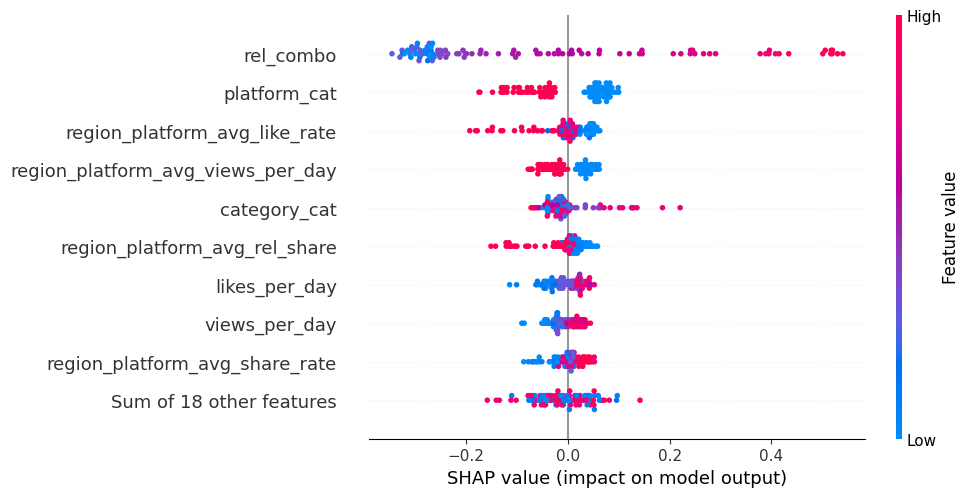

In [45]:
X_bg = X_train.sample(200, random_state=42)
X_explain = X_test.sample(100, random_state=42)

explainer = shap.Explainer(lambda data: model.predict_proba(data), X_bg, feature_names=features)
shap_values = explainer(X_explain)
classes = list(getattr(model, "class_labels_", model.named_steps["model"].classes_))
cls_idx = classes.index("trending") if "trending" in classes else 0
shap.plots.beeswarm(shap_values[:, :, cls_idx], max_display=10)






In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred_rf))
print("Macro F1:", f1_score(y_test, pred_rf, average='macro'))
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


Accuracy: 0.8374
Macro F1: 0.7983010442728448
[[5889  199  392]
 [ 227  778   15]
 [ 781   12 1707]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6480
           1       0.79      0.76      0.77      1020
           2       0.81      0.68      0.74      2500

    accuracy                           0.84     10000
   macro avg       0.82      0.78      0.80     10000
weighted avg       0.84      0.84      0.83     10000



In [47]:
sample_rows = df_clean.sample(5, random_state=42)  # or remove if not needed

test_videos = [
    row[features].to_dict()
    for _, row in balanced_samples.iterrows()
]

for _, row in sample_rows.iterrows():
    test_videos.append(row[features].to_dict())

for i, video in enumerate(test_videos):
    print(f"\n--- Test Video {i+1} ---")
    display(pd.DataFrame(video, index=[0]))



--- Test Video 1 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.31263,0.108264,0.071943,0.099262,0.031032,0.543434,0.319764,0.117476,...,0,3,9.99999,0,0.12588,0.236992,0.074647,0.153687,0.304208,0.0



--- Test Video 2 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.095362,0.051064,0.063192,0.115633,0.011027,-0.530667,0.26782,-0.118992,...,5,2,3.999996,0,0.103244,0.203507,0.059564,0.004827,0.106287,0.4588



--- Test Video 3 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,3,2.999997,0.145759,0.013734,0.073121,0.129991,0.018947,-0.263997,0.380983,0.05511,...,5,3,17.999982,0,0.125526,0.229555,0.071589,0.146339,0.338209,0.0



--- Test Video 4 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.104763,0.14361,0.021985,0.078946,0.008271,-0.479995,-0.564441,-0.390184,...,6,1,9.99999,1,0.103872,0.205414,0.059469,0.014196,0.125933,0.1511



--- Test Video 5 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,3,2.999997,0.194003,0.023569,0.030055,0.087457,0.016967,0.041162,-0.393322,-0.168624,...,5,3,5.999994,0,0.125706,0.23011,0.070345,0.146654,0.314137,0.0



--- Test Video 6 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.195775,0.032778,0.015112,0.077575,0.015187,-0.001829,-0.771241,-0.251533,...,6,1,11.999988,0,0.102893,0.201018,0.058062,0.007515,0.058156,0.0



--- Test Video 7 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,3,2.999997,0.306942,0.042264,0.211661,0.09342,0.028674,0.543064,3.010121,0.360421,...,5,3,14.999985,0,0.103244,0.203507,0.059564,0.004827,0.106287,0.0



--- Test Video 8 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,3,2.999997,0.215186,0.097574,0.148062,0.144049,0.030997,0.100915,1.811657,0.383473,...,0,1,5.999994,0,0.125526,0.229555,0.071589,0.146339,0.338209,0.0



--- Test Video 9 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,3,2.999997,0.372525,0.058916,0.083214,0.079847,0.029745,0.991586,0.588896,0.178818,...,0,2,8.999991,1,0.103177,0.207272,0.060234,0.029899,0.119752,0.1511



--- Test Video 10 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,3,2.999997,0.334572,0.049647,0.060681,0.12032,0.040256,0.682384,0.169166,0.25556,...,6,3,5.999994,0,0.103101,0.203117,0.058582,0.015032,0.096152,0.4939



--- Test Video 11 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.159517,0.110338,0.003468,0.085519,0.013642,-0.177843,-0.938238,-0.292968,...,6,2,3.999996,0,0.103274,0.209323,0.06291,0.018273,0.099448,0.0



--- Test Video 12 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.12236,0.006508,0.062449,0.072767,0.008904,-0.428182,0.046163,-0.334512,...,5,1,1.999998,0,0.103101,0.203117,0.058582,0.015032,0.096152,0.0



--- Test Video 13 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.215434,0.176926,0.039674,0.126407,0.027232,-0.020723,-0.357441,0.027257,...,3,1,3.999996,0,0.12588,0.236992,0.074647,0.153687,0.304208,0.0



--- Test Video 14 ---


,title_len,text_richness,like_rate,comment_rate,share_rate,views_per_day,likes_per_day,rel_like,rel_share,rel_combo,...,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost,region_platform_avg_views_per_day,region_platform_avg_like_rate,region_platform_avg_share_rate,region_platform_avg_rel_like,region_platform_avg_rel_share,title_sentiment
0,2,1.999998,0.143176,0.235728,0.051427,0.105363,0.015085,-0.33209,-0.16043,-0.15741,...,2,3,9.99999,1,0.103274,0.209323,0.06291,0.018273,0.099448,0.0


In [48]:


platform_map = df[['platform', 'platform_cat']].drop_duplicates().set_index('platform_cat')['platform'].to_dict()

region_map = df[['region', 'region_cat']].drop_duplicates().set_index('region_cat')['region'].to_dict()

for i, video in enumerate(test_videos):
    pred, score = rate_video(video, model)
    score_text = f"{score:.2f}/100" if score is not None else "n/a"
    print(f"Video {i+1}:")
    print(f"  Predicted Category: {pred}")
    print(f"  Trending Score: {score_text}")

    
    print(f"Platform: {platform_map[video['platform_cat']]}")
    print(f"Region: {region_map[video['region_cat']]}")

    
    if score > 60:
        print("  Interpretation: This video is highly likely to trend.")
    elif score > 20:
        print("  Interpretation: Decent performance but not strong enough to trend.")
    else:
        print("  Interpretation: Weak performance relative to region/platform norms.")
    
    print()



model = rf 



Video 1:
  Predicted Category: likely
  Trending Score: 35.34/100
Platform: tiktok
Region: Asia
  Interpretation: Decent performance but not strong enough to trend.

Video 2:
  Predicted Category: likely
  Trending Score: 1.11/100
Platform: youtube
Region: Europe
  Interpretation: Weak performance relative to region/platform norms.

Video 3:
  Predicted Category: likely
  Trending Score: 5.78/100
Platform: tiktok
Region: Americas
  Interpretation: Weak performance relative to region/platform norms.

Video 4:
  Predicted Category: low
  Trending Score: 0.14/100
Platform: youtube
Region: Africa
  Interpretation: Weak performance relative to region/platform norms.

Video 5:
  Predicted Category: low
  Trending Score: 0.53/100
Platform: tiktok
Region: MENA
  Interpretation: Weak performance relative to region/platform norms.

Video 6:
  Predicted Category: low
  Trending Score: 0.91/100
Platform: youtube
Region: Oceania
  Interpretation: Weak performance relative to region/platform norms.


In [49]:
import os, sklearn, joblib
print("Train sklearn:", sklearn.__version__)
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/trend_model.pkl")
print("Saved to ../models/trend_model.pkl")
print(os.path.exists("../models/trend_model.pkl"))

Train sklearn: 1.7.2
Saved to ../models/trend_model.pkl
True


In [50]:
import os
print(os.path.exists("../models/trend_model.pkl"))

True


In [51]:
# Save feature list and model for app explanations
import joblib, os
feature_list_path = "../models/feature_list.pkl"
model_path = "../models/trend_model.pkl"  # reuse existing name
os.makedirs("../models", exist_ok=True)
joblib.dump(features, feature_list_path)
joblib.dump(model, model_path)
joblib.dump(le, "../models/label_encoder.pkl")

print("Saved feature list to", feature_list_path)
print("Re-saved model to", model_path)
print("Feature count:", len(features))

Saved feature list to ../models/feature_list.pkl
Re-saved model to ../models/trend_model.pkl
Feature count: 27
